# Ilarduia (C068)

#### Euskalmeten Ilarduiako estazioko datuen irudikatzea.

### Under construction . . . 💻🛠️

In [1]:
# Data handling:
import numpy as np
import pandas as pd

# Data representation:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# import cmcrameri.cm as cmc

Lehenik eta behin, kargatu datuak (_download_station_readings.ipynb_ skriptarekin lortuak).

In [2]:
# Load table with station readings:
fpath = "../data/readings_C068.csv"
df = pd.read_csv(fpath, sep = ",")

Moldatu taula gure beharretara:

In [3]:
# Remove lines with no readings:
var_nms = ["temperature", "humidity", "direction_sigma", "mean_speed", "mean_direction", "speed_sigma", "max_speed", "precipitation"]
df.dropna(subset=var_nms, how="all", inplace=True)

# Create a column of type datetime:
df['timestamp'] = df['YYYY'].astype(str) + "-" + df['MM'].astype(str) + '-' + df['DD'].astype(str) + "T" + df['hh'].astype(str) + ":" + df['mm'].astype(str) + ":0"
df['timestamp'] = pd.to_datetime(df['timestamp'], format="%Y-%m-%dT%H:%M:%S", utc=True)


# Remove invalid values:
df['temperature'] = df['temperature'].replace(799.9, np.NaN)
df['humidity'] = df['humidity'].replace(7999, np.NaN)

# And values that clearly make no sense:
#
# Temperatures above 50ºC:
df['temperature'].where(df['temperature']<=50, np.NaN, inplace=True)

# I don't think water vapor supersaturation makes sense in natural conditions? Or at least high values?
#plt.show(sns.displot(data = df[df["humidity"]>100], x = "humidity"))
df['humidity'].where(df['humidity']<=110.0, np.NaN, inplace=True)
# Note, for where(), in pandas, when the condition == True, the current value in the dataframe is used. When condition == False, the other value is taken. (for numpy, the opposite)

In [4]:
### Summarise dataframe as hourly averages/sums:
daily = df.groupby(['YYYY', 'MM', 'DD']).agg(temperature_mean=('temperature', 'mean'),
                                             temperature_min=('temperature', 'min'),
                                             temperature_max=('temperature', 'max'),
                                             humidity_mean=('humidity', 'mean'),
                                             humidity_min=('humidity', 'min'),
                                             humidity_max=('humidity', 'max'),
                                             direction_sigma_mean=('direction_sigma', 'mean'),
                                             mean_speed_mean=('mean_speed', 'mean'),
                                             mean_direction_mean=('mean_direction', 'mean'),
                                             speed_sigma_mean=('speed_sigma', 'mean'),
                                             max_speed_mean=('max_speed', 'mean'),
                                             max_speed_max=('max_speed', 'max'),
                                             precipitation_sum=('precipitation', 'sum'),
                                             timestamp=('timestamp', 'min')
                                            )
# When grouping and aggregating, the grouping variables are set as indexes, but I want to keep them as variables:
daily.reset_index(names=['YYYY', 'MM', 'DD'], inplace=True)

# Add column representing the day of the year for each date (1-365)
daily['day_of_year'] = daily['timestamp'].dt.dayofyear

# Create a dummy datetime format column so that we map these days_of_year into datetime class, 
# setting an equal random year for all -> it can be useful to set readable axis labels when plotting:
daily['day_of_year_dt'] = pd.to_datetime(2022 * 1000 + daily['day_of_year'], format='%Y%j')
## NOT REALLY SURE HOW TO DEAL WITH LEAP YEARS, AS AFTER FEB-28 DAYS ARE OFFSET BY ONE RELATIVE TO THE "REAL" CALENDAR DAY.
## I MEAN, IN LEAP YEAR day_of_year 60 IS FEB-29, BUT IN REGULAR YEARS IT'S MAR-1 (MINOR OFFSET, BUT STILL)

# Add column describing whether datapoints belong to the last year in the dataset or not:
daily['is_last_year'] = np.where(daily['YYYY']==max(daily['YYYY']), True, False) 


### Summarise dataframe as monthly averages/sums:
monthly = daily.groupby(['YYYY', 'MM']).agg(temperature_mean=('temperature_mean', 'mean'),
                                            temperature_min=('temperature_min', 'min'), # lowest minimum
                                            temperature_max=('temperature_max', 'max'), # highest maximum                                       
                                            temperature_min_mean=('temperature_min', 'mean'), # mean minimum
                                            temperature_max_mean=('temperature_max', 'mean'), # mean maximum
                                            humidity_mean=('humidity_mean', 'mean'),
                                            mean_speed_mean=('mean_speed_mean', 'mean'),
                                            mean_direction_mean=('mean_direction_mean', 'mean'),
                                            max_speed_mean=('max_speed_mean', 'mean'),
                                            max_speed_max=('max_speed_max', 'max'),
                                            precipitation_sum=('precipitation_sum', 'sum'),
                                            timestamp=('timestamp', 'min')
                                           )
monthly.reset_index(names=['YYYY', 'MM'], inplace=True)
monthly['month_of_year_dt'] = pd.to_datetime(2022 * 100 + monthly['MM'], format='%Y%m')

### Summarise dataframe as yearly averages/sums:
yearly = daily.groupby(['YYYY']).agg(temperature_mean=('temperature_mean', 'mean'),
                                     temperature_min=('temperature_min', 'min'), # lowest minimum
                                     temperature_max=('temperature_max', 'max'), # highest maximum
                                     temperature_min_mean=('temperature_min', 'mean'), # mean minimum
                                     temperature_max_mean=('temperature_max', 'mean'), # mean maximum
                                     humidity_mean=('humidity_mean', 'mean'),
                                     mean_speed_mean=('mean_speed_mean', 'mean'),
                                     mean_direction_mean=('mean_direction_mean', 'mean'),
                                     max_speed_mean=('max_speed_mean', 'mean'),
                                     max_speed_max=('max_speed_max', 'max'),
                                     precipitation_sum=('precipitation_sum', 'sum'),
                                     timestamp=('timestamp', 'min')
                                    )
yearly.reset_index(names=['YYYY'], inplace=True)

# Estimate monthly climatologies:
# possibly: before estimating, remove incomplete months (or maybe easier, months with less than 25 days?)
monthly_clim = monthly.groupby(['MM']).agg(temperature_mean=('temperature_mean', 'mean'),
                                           temperature_min_mean=('temperature_min_mean', 'mean'),
                                           temperature_max_mean=('temperature_max_mean', 'mean'),
                                           temperature_min=('temperature_min', 'min'),
                                           temperature_max=('temperature_max', 'max'),                                           
                                           humidity_mean=('humidity_mean', 'mean'),
                                           mean_speed_mean=('mean_speed_mean', 'mean'),
                                           mean_direction_mean=('mean_direction_mean', 'mean'),
                                           max_speed_mean=('max_speed_mean', 'mean'),
                                           max_speed_max_mean=('max_speed_max', 'mean'),                                         
                                           precipitation_sum_mean=('precipitation_sum', 'mean')
                                          )
monthly_clim.reset_index(names=['MM'], inplace=True)
monthly_clim['month_of_year_dt'] = pd.to_datetime(2022 * 100 + monthly_clim['MM'], format='%Y%m')

# Daily climatologies:
# do not include feb-29 of leap years.
# to do that: create text column with "MM-DD", then agg based on that, then re-estimate day of year.
daily_clim = daily.groupby(['day_of_year']).agg(temperature_mean=('temperature_mean', 'mean'),
                                                temperature_min_mean=('temperature_min', 'mean'),
                                                temperature_max_mean=('temperature_max', 'mean'),
                                                temperature_min=('temperature_min', 'min'),
                                                temperature_max=('temperature_max', 'max'),
                                                humidity_mean=('humidity_mean', 'mean'),
                                                mean_speed_mean=('mean_speed_mean', 'mean'),
                                                mean_direction_mean=('mean_direction_mean', 'mean'),
                                                max_speed_mean=('max_speed_mean', 'mean'),
                                                max_speed_max_mean=('max_speed_max', 'mean'),
                                                precipitation_sum_mean=('precipitation_sum', 'mean')
                                               )
daily_clim.reset_index(names=['day_of_year'], inplace=True)
daily_clim['day_of_year_dt'] = pd.to_datetime(2022 * 1000 + daily_clim['day_of_year'], format='%Y%j')


# Estimate temperature anomalies for daily
daily['temperature_mean_anom'] = np.nan
for ir, r in daily.iterrows():

    # Get the climatological mean temperature for the day of the year in the present iteration:
    clim_temp = daily_clim.loc[daily_clim['day_of_year']==r['day_of_year'], 'temperature_mean']

    # Subtract that climatogical mean temperature to the mean temperature in this actual day:
    daily.loc[ir, 'temperature_mean_anom'] = r['temperature_mean'] - clim_temp.iloc[0] # if I do not add the '.iloc[0]' it throws an "Incompatible indexer with Series" error when assigning the value to 'daily'. Bit weird?



## Estimate average 10 minute values per month/season to get a "typical day" during different times of the year:


### Datuen irudikatzea

##### **Plot daily average temperatures over the entire dataset**

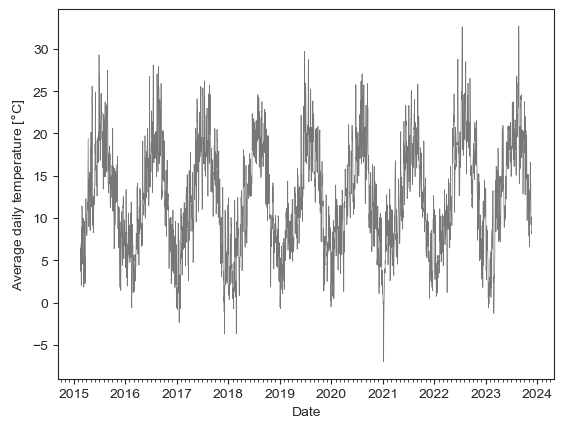

In [6]:
with sns.axes_style("ticks"):
    ts_temp = sns.lineplot(data=daily,
                           x="timestamp", y="temperature_mean",
                           linewidth=.5, c="#777777")
    ts_temp.set(xlabel="Date", ylabel="Average daily temperature [$\degree$C]")
    ts_temp.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1)))
    ts_temp.xaxis.set_minor_locator(mdates.MonthLocator())
    ts_temp.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ts_temp.xaxis.get_major_locator()))
    plt.show(ts_temp)

The same times series, but as heatmap:

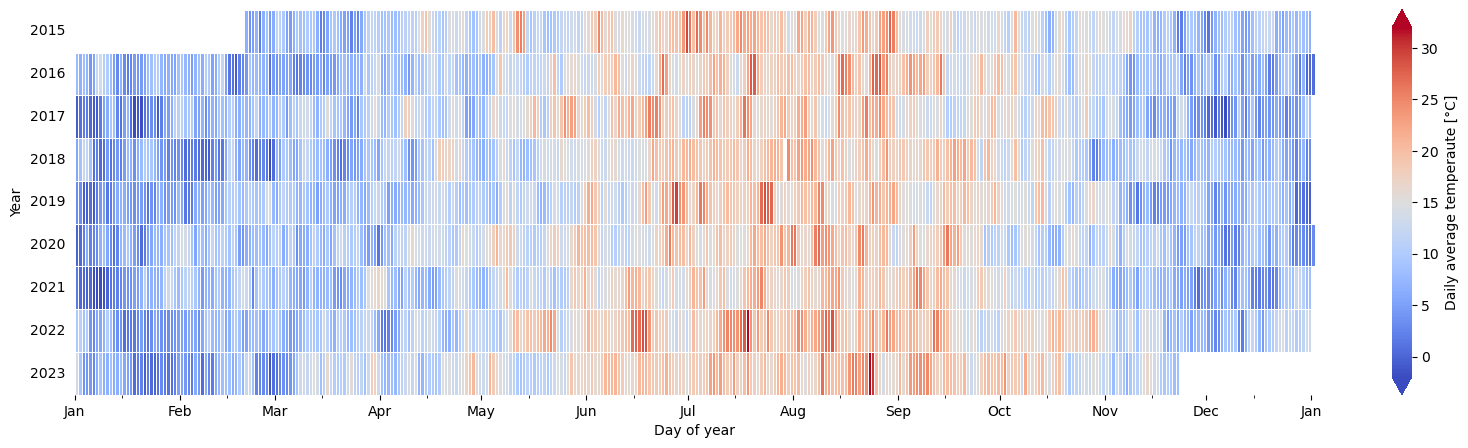

In [7]:
# Subset the temperature data along to create a matrix of data
daily_temp = daily[["YYYY", "day_of_year_dt", "temperature_mean"]].pivot(columns="day_of_year_dt", index="YYYY", values="temperature_mean")

# Before starting to plot, set the figure size to adequate values so that our data is properly visualised:
plt.figure(figsize=(20,5))
hm_temp_d = sns.heatmap(daily_temp, linewidths=.5, vmin=-2, vmax=32, 
                        cmap=sns.color_palette("coolwarm", as_cmap=True),
                        cbar_kws={"extend": "both", 'label': 'Daily average temperaute [°C]'})
hm_temp_d.set(xlabel="Day of year", ylabel="Year")
hm_temp_d.set_yticklabels(hm_temp_d.get_yticklabels(), rotation=0)
hm_temp_d.yaxis.set_ticks_position('none') 
hm_temp_d.set_xticklabels(hm_temp_d.get_xticklabels(), rotation=0)
hm_temp_d.xaxis.set_major_locator(mdates.MonthLocator())
hm_temp_d.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
hm_temp_d.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.show(hm_temp_d)

We can also visualise the annual temperature cycle by plotting the dataset by day of year:

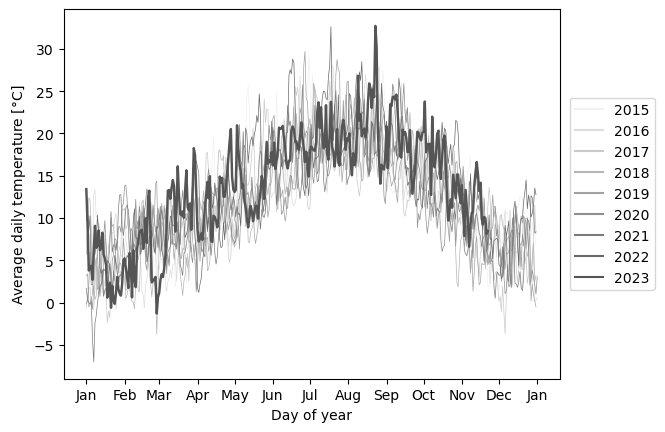

In [8]:
pal = sns.light_palette("#555555", n_colors=len(set(daily['YYYY']))) 
lp_temp = sns.lineplot(data=daily,
                       x="day_of_year_dt", y="temperature_mean",
                       hue="YYYY", palette=pal,
                       size="is_last_year", sizes=(.5,1.75), size_order=[True, False])
lp_temp.set(xlabel="Day of year", ylabel="Average daily temperature [$\degree$C]")
lp_temp.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,13)))
lp_temp.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
h,l = lp_temp.get_legend_handles_labels()
plt.legend(h[1:10], l[1:10], bbox_to_anchor=(1.02, .5), loc="center left", ncol=1, title=None, borderaxespad=0)
plt.show(lp_temp)

# Note to self: apparently the "subtitles" of the different parts of the legends (say, hue and size here) 
# can be removed/customised by treating them as labels (I mean, I guess because they are technically labels due to how seaborn handles them? idk)
# So, for instance, by not selecting the index=0 I remove the 'YYYY' heading for the hue legend

We can aid visualisation by plotting the daily average temperature along with the standard deviation (superimposing the data from the current year to see how it compares to the dataset average):

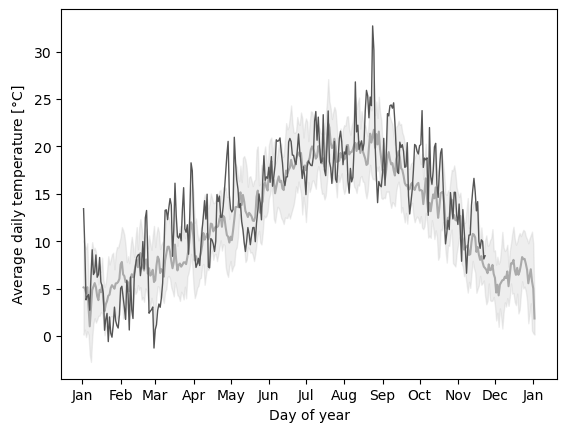

In [9]:
fig_temp_av, ax_temp_av = plt.subplots()
sns.lineplot(x="day_of_year", y="temperature_mean",
             data=daily,
             c="#aaaaaa",
             estimator="mean",
             errorbar="sd",
             ax=ax_temp_av)
sns.lineplot(x="day_of_year", y="temperature_mean",
             data=daily[daily['is_last_year']],
             c="#555555",
             linewidth=1,
             estimator=None,
             ax=ax_temp_av)
ax_temp_av.set(xlabel="Day of year", ylabel="Average daily temperature [$\degree$C]")
ax_temp_av.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,13)))
ax_temp_av.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.show(ax_temp_av)

##### **Daily mean temperature anomalies**
A bit noisy.

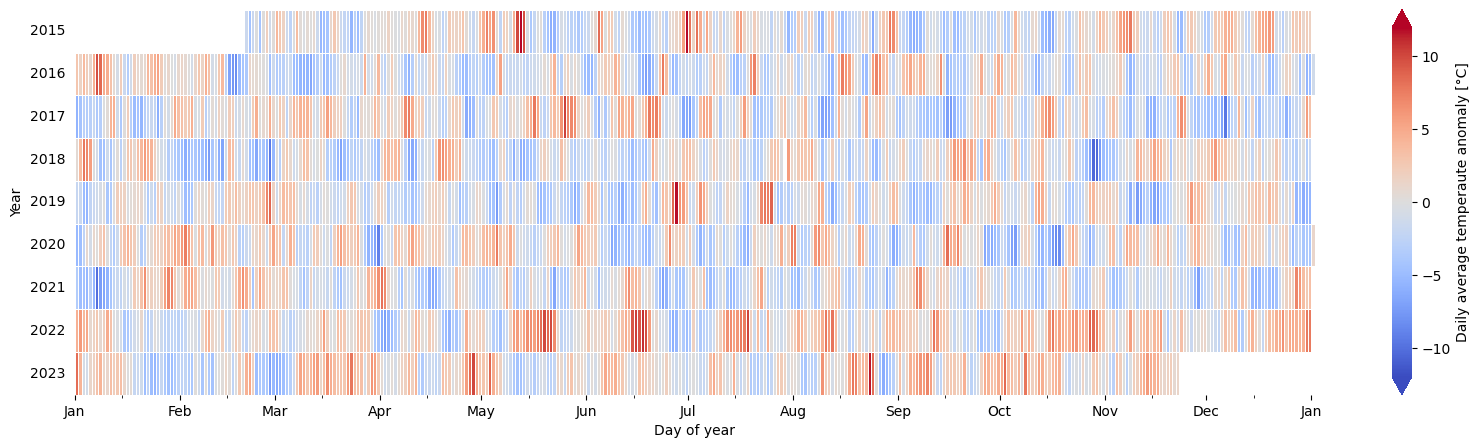

In [53]:
# Subset the temperature data along to create a matrix of data
daily_temp_anom = daily[["YYYY", "day_of_year_dt", "temperature_mean_anom"]].pivot(columns="day_of_year_dt", index="YYYY", values="temperature_mean_anom")

# Before starting to plot, set the figure size to adequate values so that our data is properly visualised:
plt.figure(figsize=(20,5))
hm_temp_d = sns.heatmap(daily_temp_anom, linewidths=.5, vmin=-12, vmax=12, 
                        cmap=sns.color_palette("coolwarm", as_cmap=True),
                        cbar_kws={"extend": "both", 'label': 'Daily average temperaute anomaly [°C]'})
hm_temp_d.set(xlabel="Day of year", ylabel="Year")
hm_temp_d.set_yticklabels(hm_temp_d.get_yticklabels(), rotation=0)
hm_temp_d.yaxis.set_ticks_position('none') 
hm_temp_d.set_xticklabels(hm_temp_d.get_xticklabels(), rotation=0)
hm_temp_d.xaxis.set_major_locator(mdates.MonthLocator())
hm_temp_d.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
hm_temp_d.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.show(hm_temp_d)

In [10]:
# do this with daily min vs max temps: https://seaborn.pydata.org/examples/layered_bivariate_plot.html

### Precipitation

Times series of daily precipitations:

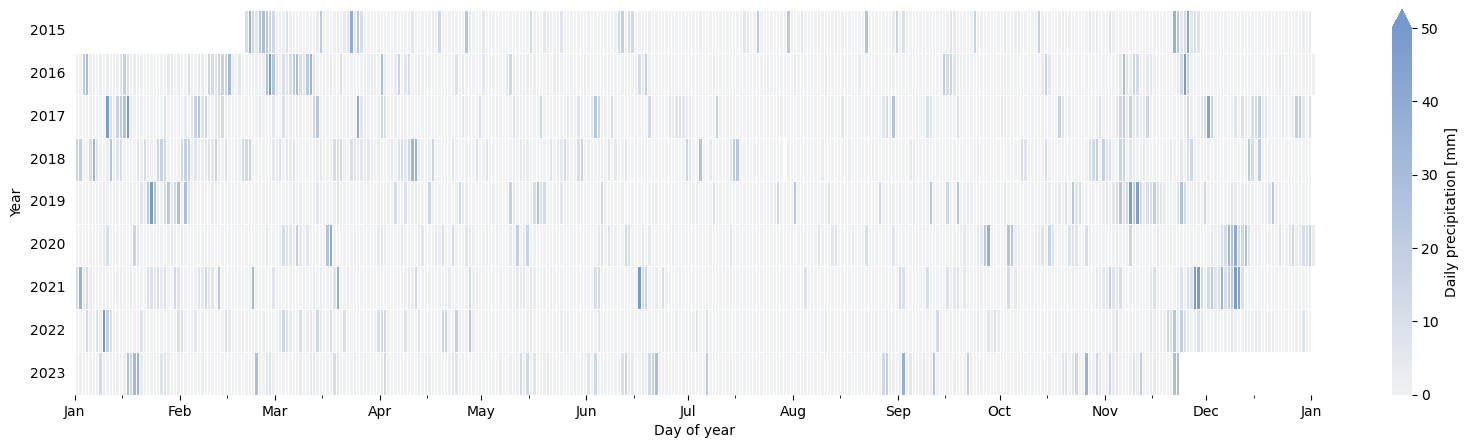

In [11]:
# Create precipitation heatmap with day-of-year vs year axes.
#
# Subset the precipitation data along to create a matrix of data
daily_prec = daily[["YYYY", "day_of_year_dt", "precipitation_sum"]].pivot(columns="day_of_year_dt", index="YYYY", values="precipitation_sum")

# Before starting to plot, set the figure size to adequate values so that our data is properly visualised:
plt.figure(figsize=(20,5))
hm_prec_d = sns.heatmap(daily_prec, linewidths=.5, vmin=0, vmax=50, 
                        cmap=sns.color_palette("light:#79c", as_cmap=True),
                        cbar_kws={"extend": "max", 'label': 'Daily precipitation [mm]'})
hm_prec_d.set(xlabel="Day of year", ylabel="Year")
hm_prec_d.set_yticklabels(hm_prec_d.get_yticklabels(), rotation=0)
hm_prec_d.yaxis.set_ticks_position('none') 
hm_prec_d.set_xticklabels(hm_prec_d.get_xticklabels(), rotation=0)
hm_prec_d.xaxis.set_major_locator(mdates.MonthLocator())
hm_prec_d.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
hm_prec_d.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.show(hm_prec_d)

To have a better idea of seasonality, replot with monthly accumulations:

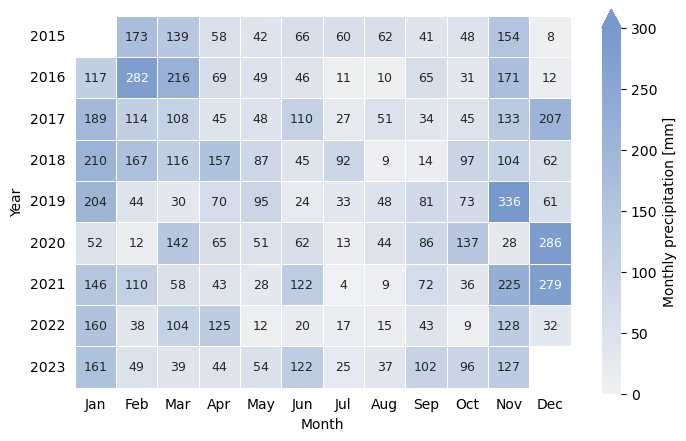

In [12]:
monthly_prec = monthly[["YYYY", "month_of_year_dt", "precipitation_sum"]].pivot(columns="month_of_year_dt", index="YYYY", values="precipitation_sum")

# Before starting to plot, set the figure size to adequate values so that our data is properly visualised:
plt.figure(figsize = (8,5))
hm_prec_m = sns.heatmap(monthly_prec, linewidths=.5, vmin=0, vmax=300, 
                        cmap=sns.color_palette("light:#79c", as_cmap=True),
                        cbar_kws={"extend": "max", 'label': 'Monthly precipitation [mm]'},
                        annot=True, fmt=".0f", annot_kws={"size" : 9},
                        square=True)
hm_prec_m.set(xlabel="Month", ylabel="Year")
hm_prec_m.set_yticklabels(hm_prec_m.get_yticklabels(), rotation=0)
hm_prec_m.set_xticklabels(monthly_prec.columns.strftime('%b'), rotation=0)
hm_prec_m.xaxis.set_ticks_position('none')
hm_prec_m.yaxis.set_ticks_position('none') 
# I was not able to set the ticks and labels as before, I do not know why
plt.show(hm_prec_m)

Show the average precipitations per month over the time series:

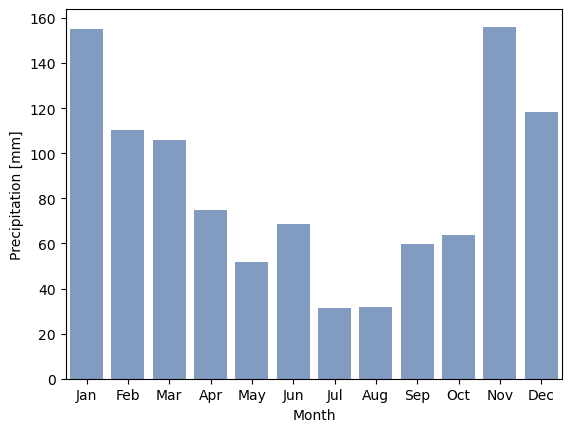

In [13]:
bp_prec_mclim = sns.barplot(data=monthly_clim,
                      x='month_of_year_dt', y = "precipitation_sum_mean",
                      color="#79c")
bp_prec_mclim.set(xlabel="Month", ylabel="Precipitation [mm]")
bp_prec_mclim.set_xticklabels(monthly_clim.month_of_year_dt.dt.strftime('%b'), rotation=0)
plt.show(bp_prec_mclim)

Yearly accumulated precipitation:

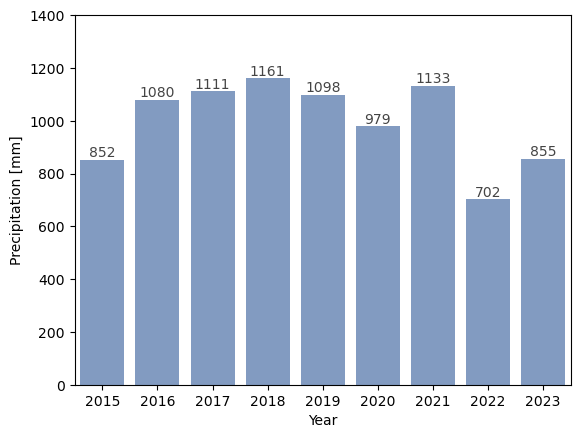

In [14]:
bp_yprec = sns.barplot(data=yearly,
                      x='YYYY', y = "precipitation_sum",
                      color="#79c")
bp_yprec.set(xlabel="Year", ylabel="Precipitation [mm]", ylim=[0, 1400])
for container in bp_yprec.containers:
    bp_yprec.bar_label(container, fmt='%.0f', c="#444")
plt.show(bp_yprec)

### Wind

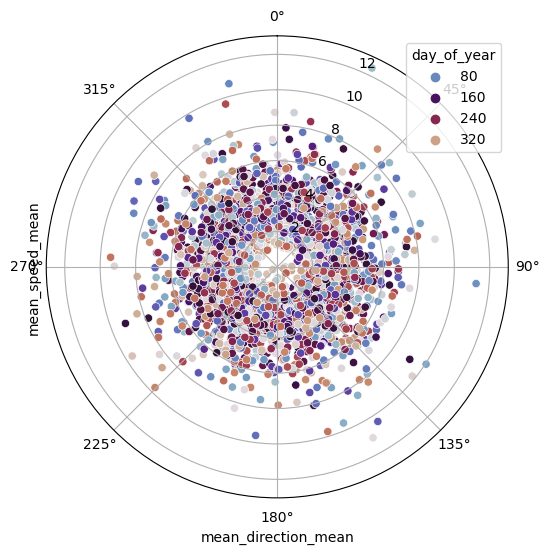

In [15]:
fig_w_daily, ax_w_daily = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'polar'})
cmap = mpl.colormaps['twilight']
sc_w = sns.scatterplot(
    data=daily,
    x="mean_direction_mean", y="mean_speed_mean",
    hue="day_of_year",
    palette=cmap,
)
ax_w_daily.set_theta_zero_location("N")  # theta=0 at the top
ax_w_daily.set_theta_direction(-1)  # theta increasing clockwise
# plt.figure.colorbar(sc_w)


### Irradiance

##### This station has no irradiance data but, if we had it, we could estimate some useful parameters:

[According to WMO (2010)](https://library.wmo.int/doc_num.php?explnum_id=3154), sunshine duration during a given period is defined as the sum of the time for which the direct solar irradiance exceeds 120 W·m<sup>-2</sup>.

Maximum possible sunshine duration (N) depends on the latitude of the site and the solar declination angle, and can be estimated with the following [expression](https://doi.org/10.1016/j.rser.2015.05.068):

$$ N = {2\over15}\times arccos(−tan(\varphi) \times tan(\delta)) $$

where $\varphi$ is the latitude of the site under consideration (in the range of −90 ≤ $\varphi$ ≤ +90) and $\delta$ is the solar declination given by the following expression:

$$ \delta = 23.4 \times \sin({360\over365}\times(284 + d)) $$

where ___d___ is the day of the year, starting from _1_ for January 1<sup>st</sup>.
